# **Analisis Sentimen Fenomena Sound Horeg yang tengah Viral**

Data diambil dari komentar video youtube Steaven Young dan Volix Media yang membahas tentang fenomena sound Horeg. Berikut linknya:
<ul>
<li><a href="https://youtu.be/PpWz7_nQ2bs?si=100qrBr8thRYEjSp">Steaven Young</a></li>
<li><a href="https://youtu.be/S7Bj0F88Iys?si=to3Dx5MEs5-JiSmD">Volix Media</a></li>
</ul>

<img src='image/horeg.webp' height='400'/>

## **Import Required Library**

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [22]:
nltk.download('stopwords')
stopwords_id = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Load Data**

In [23]:
df = pd.read_csv('raw/raw_and_label.csv')
df = df.rename(columns={'Sentimen': 'sentimen'})
df = df.astype({'sentimen':int})
df.head()

,username,komentar,sentimen
0,@GeraldCooney,"anehnya pecinta sound horeg, kalau pakai genre...",-1
1,@Supersonicec,"maaf kak, acara sound horeg itu juga melalui j...",1
2,@NATARoam,Pro: kalau digunakan di tempat lapang\nKontra:...,0
3,@hisyamarif156,"Gua sesuka apapun sama suatu lagu, gua selalu ...",-1
4,@mk_reall,"Betul ini mah, di desaku yang kemarin sama kep...",-1


## **Explore Data**

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  498 non-null    object
 1   komentar  500 non-null    object
 2   sentimen  500 non-null    int32 
dtypes: int32(1), object(2)
memory usage: 9.9+ KB


In [25]:
df = df.drop(columns='username')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   komentar  500 non-null    object
 1   sentimen  500 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 6.0+ KB


In [27]:
df.isna().sum()

komentar    0
sentimen    0
dtype: int64

### **Class Distribution**

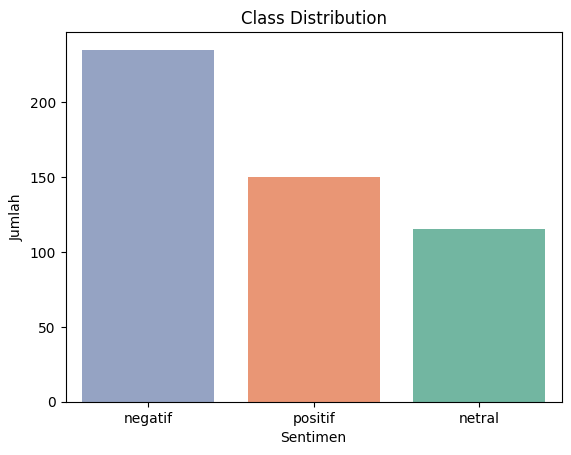

In [28]:
x = df.sentimen.value_counts()
bar = sns.barplot(x=['negatif', 'positif', 'netral'], y=x, palette='Set2', hue=x, legend=False)
plt.gca().set_title('Class Distribution')
plt.gca().set_xlabel('Sentimen')
plt.gca().set_ylabel('Jumlah')
plt.show()

### **PIE Chart**

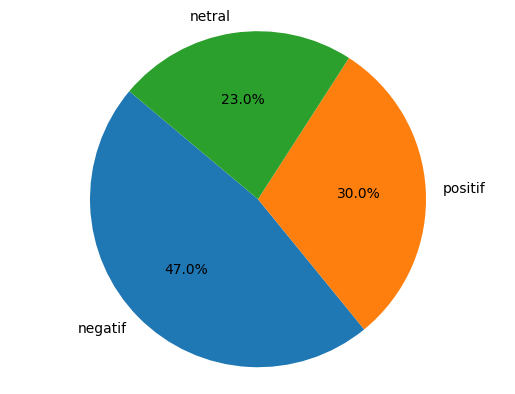

In [29]:
x = df.sentimen.value_counts()
fig1 = plt.figure()
fig1.add_subplot(111)
plt.pie(x, labels= ['negatif', 'positif', 'netral'], autopct='%1.1f%%', startangle=140)    
plt.axis('equal')    
plt.show()

### **Common Stopword in Comments**

In [30]:
def create_corpus(sentimen):
    corpus = []
    for list_words in df[df['sentimen']==sentimen]['komentar'].str.split():
        for word in list_words:
            corpus.append(word.lower())
    return corpus

def common_stopwords(sentimen):
    sentm = {-1:'Negatif',
             0:'Netral',
             1:'Positif'}
    corpus = create_corpus(sentimen=sentimen)
    list_stop = {}
    dict1 = Counter(corpus)
    for k, v in dict1.items():
        if k in stopwords_id:
            list_stop[k] = v
    
    top_result = sorted(list_stop.items(), key=lambda x: x[1], reverse=True)[:10]

    x, y = zip(*top_result)
    plt.bar(x, y)
    plt.title(sentm[sentimen])
    plt.show()

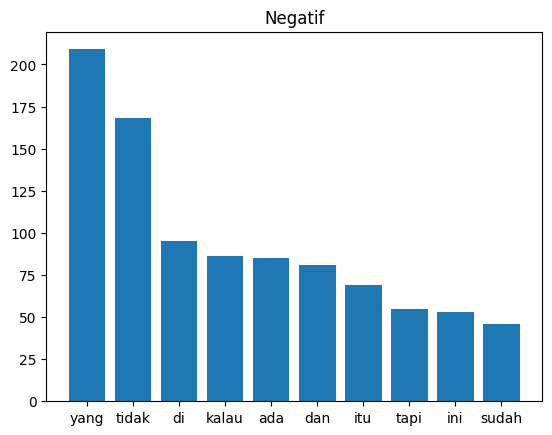

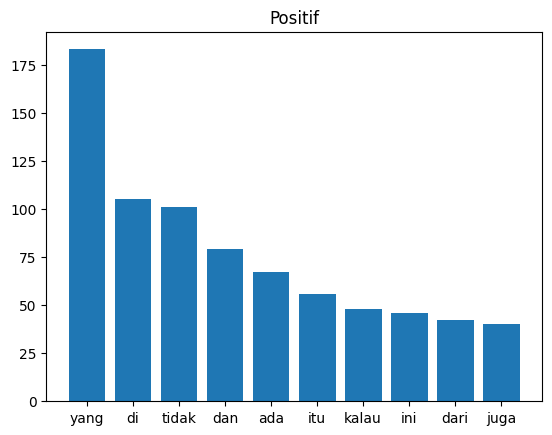

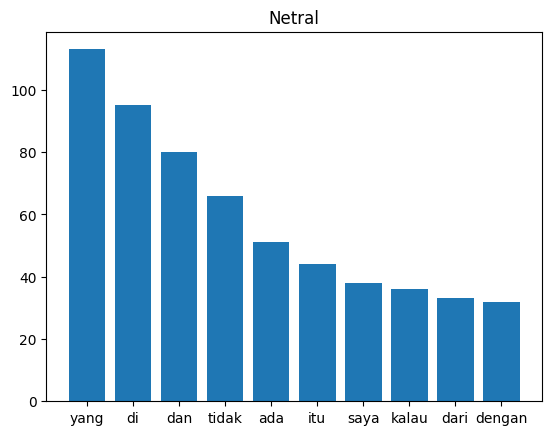

In [31]:
for sentimen in df.sentimen.unique():
    common_stopwords(sentimen)

### **Common Words in Comments (Not in Stopword)**

In [32]:
def common_words(sentimen):
    sentm = {-1:'Negatif',
             0:'Netral',
             1:'Positif'}
    corpus = create_corpus(sentimen=sentimen)
    list_stop = {}
    dict1 = Counter(corpus)
    for k, v in dict1.items():
        if k not in stopwords_id:
            list_stop[k] = v
    
    top_result = sorted(list_stop.items(), key=lambda x: x[1], reverse=True)[:10]

    x, y = zip(*top_result)
    sns.barplot(x=y, y=x, palette='Set3', hue=x, legend=False)
    plt.title(sentm[sentimen])
    plt.show()

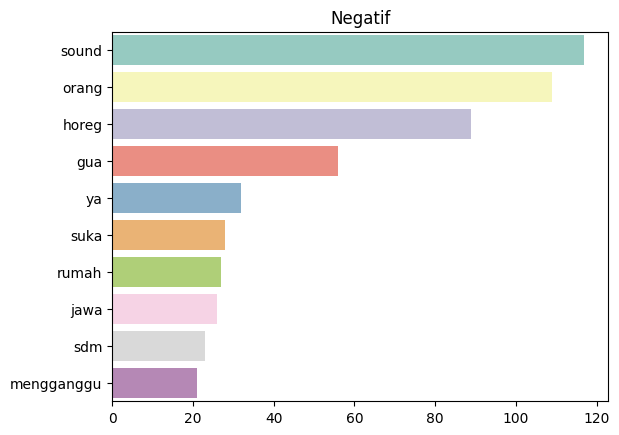

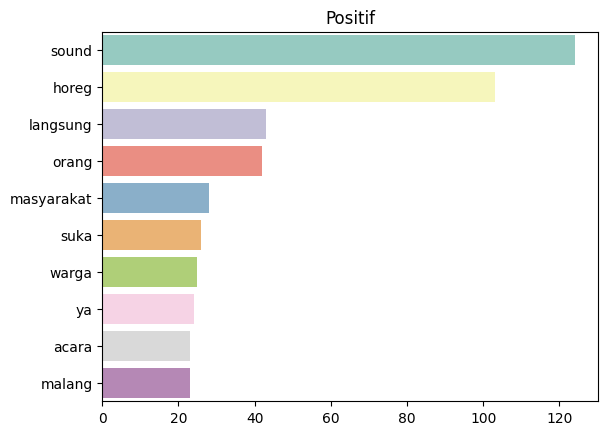

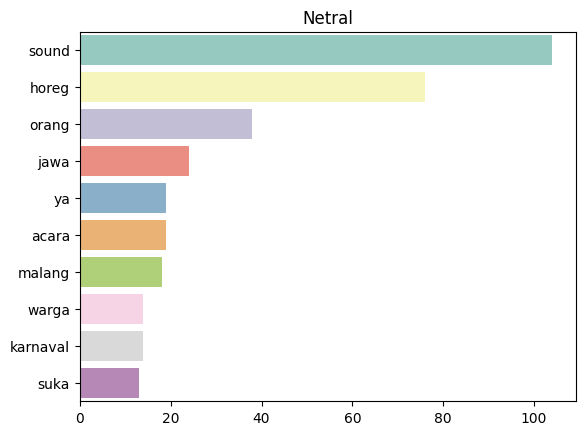

In [33]:
for sentimen in df.sentimen.unique():
    common_words(sentimen)

### **Word Cloud**

In [ ]:
def word_cloud(sentimen):
    sentm = {-1:'Negatif',
             0:'Netral',
             1:'Positif'}
    corpus = create_corpus(sentimen)
    corpus_text = " ".join(corpus)
    wc = WordCloud(background_color="white", max_words=200,
               stopwords=stopwords_id, max_font_size=128,
               random_state=42)
    wc.generate(corpus_text)
    plt.title(sentm[sentimen])
    plt.imshow(wc)
    plt.show()

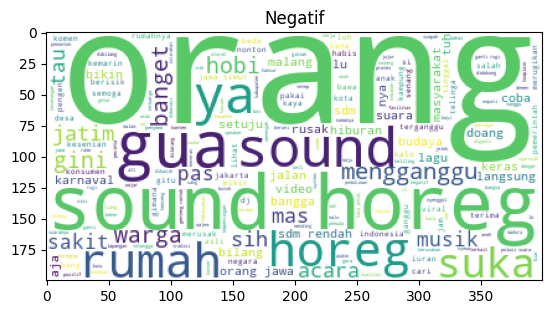

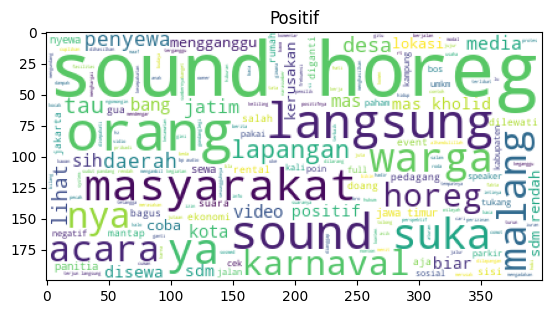

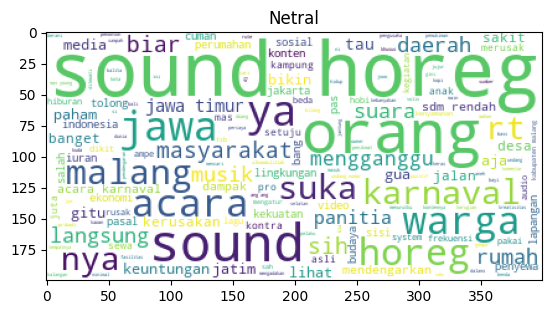

In [35]:
for sentimen in df.sentimen.unique():
    word_cloud(sentimen)

## **Data Cleaning**

### **Case Folding**

In [36]:
df.komentar = df.komentar.apply(lambda x: x.lower())

### **Removing URLs**

In [37]:
def remove_url(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', text)

df.komentar = df.komentar.apply(lambda x: remove_url(x))

### **Removing Punctuations**

In [38]:
def remove_punct(text):
  table = str.maketrans('','',string.punctuation)
  return text.translate(table)

df.komentar = df.komentar.apply(lambda x: remove_punct(x))

### **Removing Stopwords**

In [39]:
def remove_stopwords(text):
    list_word = []
    sentences = text.split()
    for word in sentences:
        if word.strip() not in stopwords_id:
            list_word.append(word.strip())
    return " ".join(list_word)

df.komentar = df.komentar.apply(lambda x: remove_stopwords(x))

### **Stemming using Sastrawi**

In [40]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming_word(text):
    return stemmer.stem(text)

df.komentar = df.komentar.apply(lambda x: stemming_word(x))

## **Preprocessing Data**

### **Tokenizing**

In [41]:
count_vect = CountVectorizer() 
countsv = count_vect.fit_transform(df.komentar)

transformer = TfidfTransformer().fit(countsv) 
countsv = transformer.transform(countsv)

### **Split Data**

In [66]:
X_train, X_test, y_train, y_test = train_test_split(countsv, df.sentimen, test_size=0.15, random_state=2)

## **Model & Training**

In [67]:
model = MultinomialNB().fit(X_train, y_train)

## **Train-Model Accuracy** 

In [68]:
train_predicted = model.predict(X_train)
skor_train = np.mean(train_predicted == y_train)
skor_train

0.7811764705882352

### **Confusion Matrix Train Data**

In [69]:
cm = confusion_matrix(y_train, train_predicted, labels=model.classes_)
cm

array([[191,   0,   3],
       [ 59,  39,   7],
       [ 24,   0, 102]], dtype=int64)

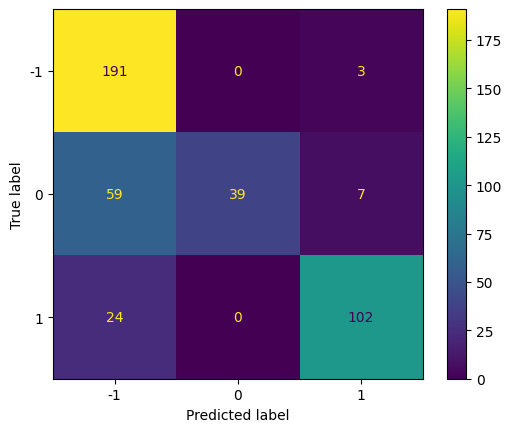

In [70]:
disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
disp.plot()
plt.show()

### **Classification Data Train Report** 

In [71]:
print("Classification Report (Train Data): \n", classification_report(y_train, train_predicted))

Classification Report (Train Data): 
               precision    recall  f1-score   support

          -1       0.70      0.98      0.82       194
           0       1.00      0.37      0.54       105
           1       0.91      0.81      0.86       126

    accuracy                           0.78       425
   macro avg       0.87      0.72      0.74       425
weighted avg       0.84      0.78      0.76       425



## **Test-Model Accuracy** 

In [72]:
test_predicted = model.predict(X_test)
skor_test = np.mean(test_predicted == y_test)
skor_test

0.7066666666666667

### **Confusion Matrix Test Data**

In [73]:
cm = confusion_matrix(y_test, test_predicted, labels=model.classes_)
cm

array([[41,  0,  0],
       [ 7,  1,  2],
       [13,  0, 11]], dtype=int64)

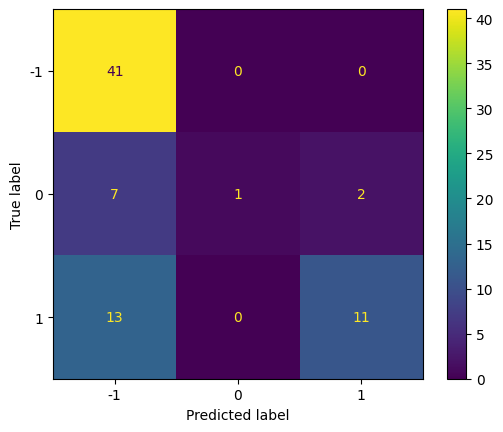

In [74]:
disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
disp.plot()
plt.show()

### **Classification Data Test Report** 

In [75]:
print("Classification Report (Test Data): \n", classification_report(y_test, test_predicted))

Classification Report (Test Data): 
               precision    recall  f1-score   support

          -1       0.67      1.00      0.80        41
           0       1.00      0.10      0.18        10
           1       0.85      0.46      0.59        24

    accuracy                           0.71        75
   macro avg       0.84      0.52      0.53        75
weighted avg       0.77      0.71      0.65        75



## **Saving Model**

In [ ]:
vectorizer_file = open("model/vectorizer.b", "wb") 
pickle.dump(countsv, vectorizer_file)

nb_file = open("model/nb.b", "wb") 
pickle.dump(model, nb_file)

vectorizer_file.close() 
nb_file.close()